In [69]:
import json
import numpy as np
import matplotlib.pyplot as plt

debug_level = 0
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Aggregation of all line solutions, represented as statistical distribution 
# 1.0 - always set,  0.0 - always unset 
class Variants:
    def __init__(self, variants):
        self.aggregate = None
        self.count = 0
        for var in variants:
            if self.aggregate is None:
                self.aggregate = np.zeros((var.sum()))
            self.aggregate += var.unpack()
            self.count += 1
        if self.count:
            self.aggregate /= self.count
    def __repr__(self):
        return f"Variants {self.aggregate}"
        
# Packed representation of one line solution
# Even colums represent unset field, odd colums represent set fields
# [0, 1, 3, 2] represents [.X...XX]
class Variant:
    def __init__(self, list):
        self.list = list
    def __repr__(self):
        return f"Variant {self.str()} {[x for x in self.list]}"
    def str(self):
        out = ""
        for i in self.unpack():
            out += 'X' if i else '.'
        return out
    def sum(self):
        return sum(self.list)
    # Unpack to array where 1: occupied, 0: empty
    def unpack(self):
        out = np.zeros(sum(self.list))
        index = 0
        for i in range(len(self.list)):
            for j in range(self.list[i]):
                out[index] = 1 if i%2 else 0
                index += 1
        return out
    # Is compatible with already laid down pieces?
    def can_fit(self, known_pieces):
        if not len(known_pieces): return True
        unpacked = self.unpack()
        if len(known_pieces) != len(unpacked): return False
        for i,j in zip(unpacked, known_pieces):
            if (j==1 or j==0) and (i!=j): return False
        return True
    
        
# Given specification of one line (row or column). E.g. [1,5,2]
class Seq:
    def __init__(self, list):
        self.list = list
        self.cached = None
    def __repr__(self):
        return f"Seq {self.list}"
    # partial - partially built list of this combination
    def variants(self, width, known_pieces=[], partial=[]):  
        if self.cached is None:
            self.cached = [variant for variant in self.get_variants(width, partial)]
        for variant in self.cached:
        # for variant in self.get_variants(width, partial):
            print(variant)
            yield variant 
        
    def get_variants(self, width, partial=[]):  
        if debug_level > 1: print(f'remain={self.list}, partial={partial}')
        if not self.list:
            # Successfully emptied all requirements
            finished = Variant(partial + [width - sum(partial)])
            yield finished
            return
        # Item that will be placed
        first = self.list[0]
        # Minimum space needed to fit all the remaining ones
        reserved = sum(self.list[1:]) + len(self.list[1:])
        for i in range(0 if not partial else 1, 1 + width - (first + reserved + sum(partial))):
            yield from Seq(self.list[1:]).get_variants(width, partial + [i, first])

# Solving matrix
class Field:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.mat = np.full((len(self.rows), len(self.cols)), 0.5)
        self.npass = 0
    def __repr__(self):
        return f'{self.mat}'
    def solve_step(self):
        # Odd passes - rows. Even passes - columns
        previous_mat = self.mat.copy()
        is_col = self.npass % 2 == 1
        if debug_level > 0: print("column pass") if is_col else print("row pass")
        if is_col:
            lines = self.cols
            length = self.mat.shape[0]
        else:
            lines = self.rows
            length = self.mat.shape[1]
        
        if debug_level > 1: print(f'{length=}, {lines=}')
        for i in range(len(lines)):
            known_pieces = self.mat[:,i] if is_col else self.mat[i,:]
            # print(f'{known_pieces=}')
            variants = Variants(lines[i].variants(length, known_pieces))
            print(variants)
            for j in range(len(variants.aggregate)):
                prob = variants.aggregate[j]
                if prob == 0 or prob == 1:
                    row = j if is_col else i
                    col = i if is_col else j
                    self.mat[row,col] = prob

        self.npass += 1
        return (previous_mat != self.mat).any()
    
    def visualize(self):
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(self.mat, cmap='terrain_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, self.mat.shape[1])
        ax.set_ylim(self.mat.shape[0], 0)
        plt.show()

In [70]:
debug_level = 0
print(Variants(Seq([2,1,1]).variants(7))) # All possibilities
print(Variants(Seq([2,1,1]).variants(7, [0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5 ]))) # Filtered by known pieces


Variant XX.X.X. [0, 2, 1, 1, 1, 1, 1]
Variant XX.X..X [0, 2, 1, 1, 2, 1, 0]
Variant XX..X.X [0, 2, 2, 1, 1, 1, 0]
Variant .XX.X.X [1, 2, 1, 1, 1, 1, 0]
Variants [0.75 1.00 0.25 0.50 0.50 0.25 0.75]
Variant XX.X.X. [0, 2, 1, 1, 1, 1, 1]
Variant XX.X..X [0, 2, 1, 1, 2, 1, 0]
Variant XX..X.X [0, 2, 2, 1, 1, 1, 0]
Variant .XX.X.X [1, 2, 1, 1, 1, 1, 0]
Variants [0.75 1.00 0.25 0.50 0.50 0.25 0.75]


Variants [0.33 0.67 1.00 0.67 0.33]
Variants [0.20 0.20 0.20 0.20 0.20]
Variants [0.20 0.20 0.20 0.20 0.20]
Variants [1.00 0.00 1.00 1.00 1.00]
Variants [0.50 0.33 0.33 0.33 0.50]
Variants [0.50 1.00 1.00 1.00 0.50]


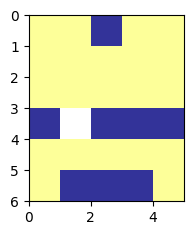

Variants [0.33 0.67 1.00 1.00 0.67 0.33]
Variants [0.33 0.33 0.33 0.00 0.00 1.00]
Variants [1.00 0.00 0.00 1.00 0.00 1.00]
Variants [0.50 0.50 0.00 1.00 0.00 1.00]
Variants [0.00 0.33 0.67 1.00 0.67 0.33]


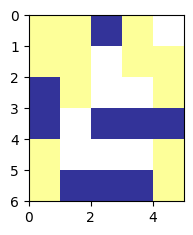

Variants [0.33 0.67 1.00 0.67 0.33]
Variants [0.20 0.20 0.20 0.20 0.20]
Variants [0.20 0.20 0.20 0.20 0.20]
Variants [1.00 0.00 1.00 1.00 1.00]
Variants [0.50 0.33 0.33 0.33 0.50]
Variants [0.50 1.00 1.00 1.00 0.50]


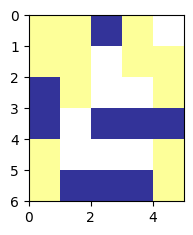

Unsolved


In [50]:
# Read test data and solve
with open('gridler.train.json.txt') as f:
    data = json.load(f)

rows = [Seq(row) for row in data['rows']]
cols = [Seq(col) for col in data['columns']]
field = Field(rows, cols)

while field.solve_step():
    field.visualize()

field.visualize()
print("Solved (without branching)") if not 0.5 in field.mat else print("Unsolved")

# Current state:
#  Slow
#  Has to walk through all possibilites
#  No branching support 
#  Can't handle big matrixes
#  Hopefully correct :-)

